# Case-study: use of PIC-SURE API to extract data from the Jackson Heart Study cohort

## INTRO - Install the required libraries

Here we set up the JupyterNB environment. We also install the newly created package picsuRe to facilitate the use of the PIC-SURE API

In [1]:
httr::set_config(httr::config(ssl_verifypeer = 0L, ssl_verifyhost = 0L, ssl_verifystatus  = 0L))
if (!file.exists(Sys.getenv("TAR")))  Sys.setenv(TAR = "/bin/tar")

#install.packages("devtools", repos = "http://cran.r-project.org")
#install.packages("reticulate", repos = "http://cran.r-project.org")
#install.packages("ggplot2", repos = "http://cran.r-project.org")
#install.packages("ggthemes",repos = "https://cran.cnr.berkeley.edu/")   

library(devtools)
library(reticulate)
library(ggplot2)
library(ggthemes)

#install_github("hms-dbmi/picsuRe")
#install_github("kaz-yos/tableone")
library(picsuRe)
library(tableone)

## 1. Data extraction
`environment`: The URL of the environment

`key`: To authenticate with PIC-SURE put your key or token in an otherwise empty text file in your JupyterNotebook's top level folder. The key will be read from there so the key does not get seen by anyone except you.

`variables`: A vector with the variables of interest. You can put a variable, or a path, as you want. You can also use the * key if you want to use a wild card. If an argument corresponds to a node, it will return all the variables below the node

In [2]:
env <- "https://topmed-dev.hms.harvard.edu"
key <- as.character(read.table("topmedkey.csv", sep=",")[1,1])

var <- c(Consent_groups = "The Jackson Heart Study - phs000286/00. population/consent_groups",
               Age = "Age (yrs) at baseline clinic visit",
               Gender = "01. Demographics/Gender",
               Diabetes = "Diabetes status (Type I or II)",
               LV_thickness = "M-mode diastolic IV septum thickness in mm",
               Smoking = "*Smoked at least 400 cigarettes",
               Diastolic_BP = "*Diastolic (first BP)")

With the function `picsure`, we build our query, and get the results back from the API. The output is a dataset with the variables of interests. By default, it will return all the patients that have at least one value for a variable.

In [3]:
demo <- picsure(env, key, var)

Next time, try using the token instead of the key. If you want a demo, ask the developpers.
Hi Laura_Versmee thank you for using picsuRe!

Waiting for PIC-SURE to return the query
  ...still waiting
  ...still waiting
  ...still waiting

The data.frame downloaded contains 3602 observations of 8 variables. Its size is 144.2 Kb


For simplicity, we exclude the observations where "Gender" is missing

In [4]:
demo <- demo[!(demo$Gender == ""),]

## 2. Use the data to make statistics
### 2.a. Summary statistics
Let's take a look at the characteristics of our population

In [5]:
catVars <- c("Consent_groups", "Gender", "Diabetes", "Smoking")
vars <- c("Consent_groups", "Gender", "Diabetes", "Smoking", "LV_thickness", "Age", "Diastolic_BP")
paste("We have", nrow(demo), "patients in our population.")
"Table 1: Description of the population from the Jackson Study"
CreateTableOne(vars, data = demo[,-1], factorVars = catVars, strata = c("Gender"), test = FALSE)

[1] "We have 3536 patients in our population."

[1] "Table 1: Description of the population from the Jackson Study"

                          Stratified by Gender
                           Female        Male          
  n                         2214          1322         
  Consent_groups (%)                                   
     1                       300 (13.6)    178 ( 13.5) 
     2                       110 ( 5.0)     65 (  4.9) 
     3                      1291 (58.3)    806 ( 61.0) 
     4                       513 (23.2)    273 ( 20.7) 
  Gender = Male (%)            0 ( 0.0)   1322 (100.0) 
  Diabetes (%)                                         
                              47 ( 2.1)     28 (  2.1) 
     Absent                 1710 (77.2)   1066 ( 80.6) 
     Present                 457 (20.6)    228 ( 17.2) 
  Smoking (%)                                          
                               4 ( 0.2)      2 (  0.2) 
     No                     1630 (73.6)    734 ( 55.5) 
     Yes                     580 (26.2)    586 ( 44.3) 
  LV_thickness (mean (sd))  8.61 (1.38)   9.27 (1.52)  
 

### 2.b. Comparison of a categorical variable with a continuous one.
#### 2.b.1. Comparison of Age among male and female
We want to start by looking at the distribution of age in our population

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20.00   45.00   55.00   54.86   64.00   95.00 

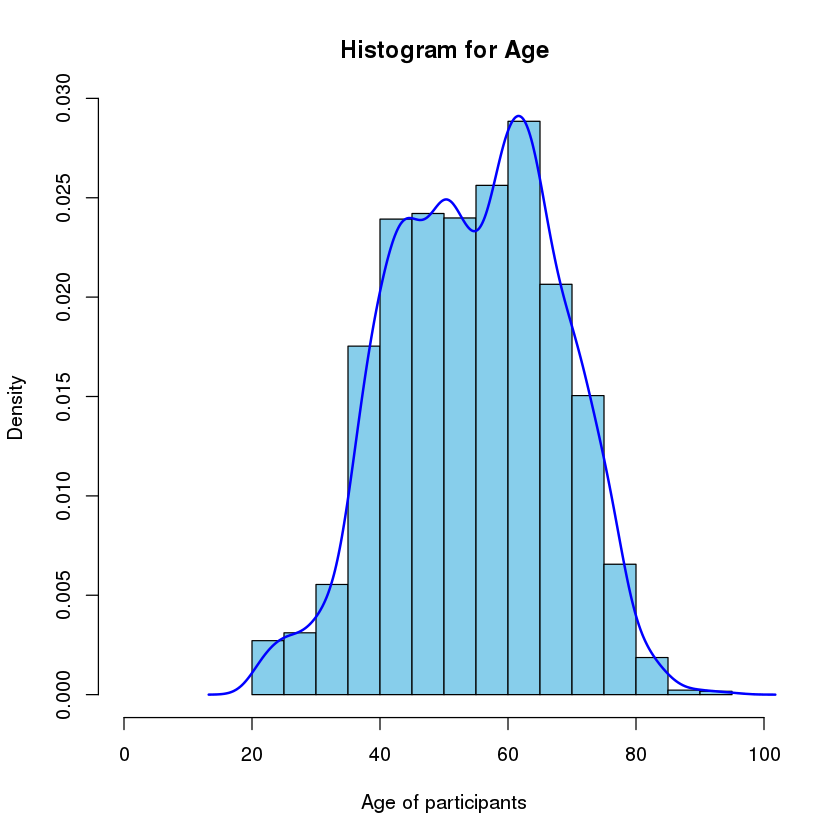

In [6]:
age <- demo$Age
summary(age)
hist(age,
     main="Histogram for Age", 
     xlab="Age of participants", 
     border="black", 
     col="sky blue",
     xlim=c(0,100),
     breaks=20,
     prob = TRUE)
lines(density(age), col = "blue", lwd = 2)

We can notice a bi-modal distribution of age among the participants, with one mode around 50 years old, and the other around 65 years old.

##### Now let's break down the distribution of age by gender categories.

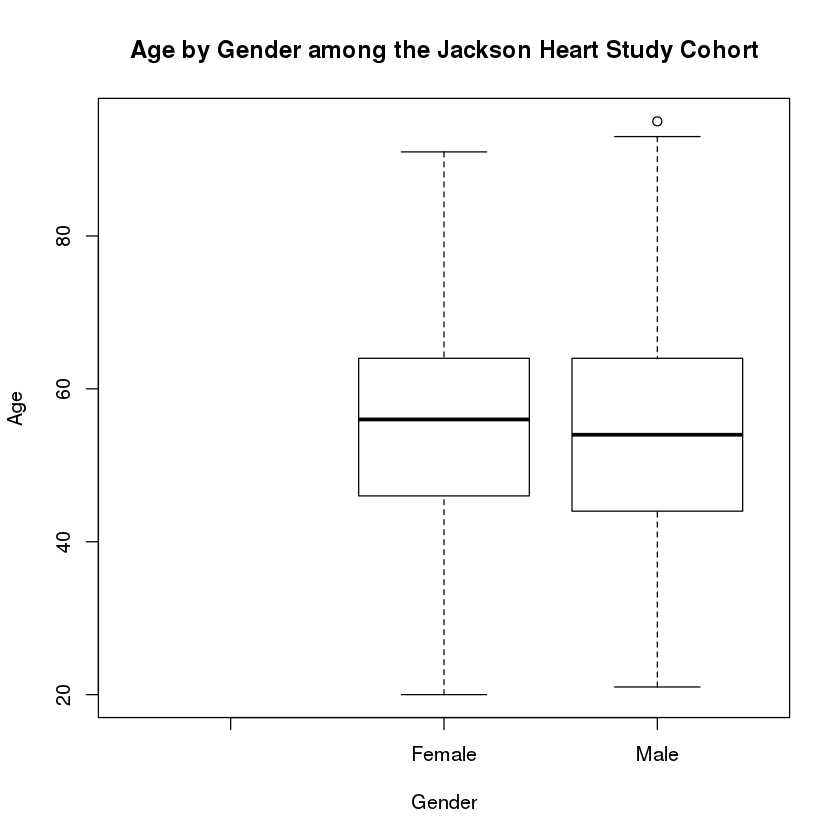

In [7]:
Age <- demo$Age
demo2 <- demo$Gender
demo2 <- droplevels(demo2)

boxplot(Age~Gender,data=demo, main="Age by Gender among the Jackson Heart Study Cohort", xlab="Gender", ylab="Age")

The distribution of age appears to be similar among men and women with a mean around 50 to 55 years old.

### 2.b.2. Comparison of the sitting blood pressure among men and women from the JHS cohort
First, let's see the distribution of the diastolic blood pressure among the JHS cohort

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  60.00   88.00   96.00   95.83  104.00  140.00      10 

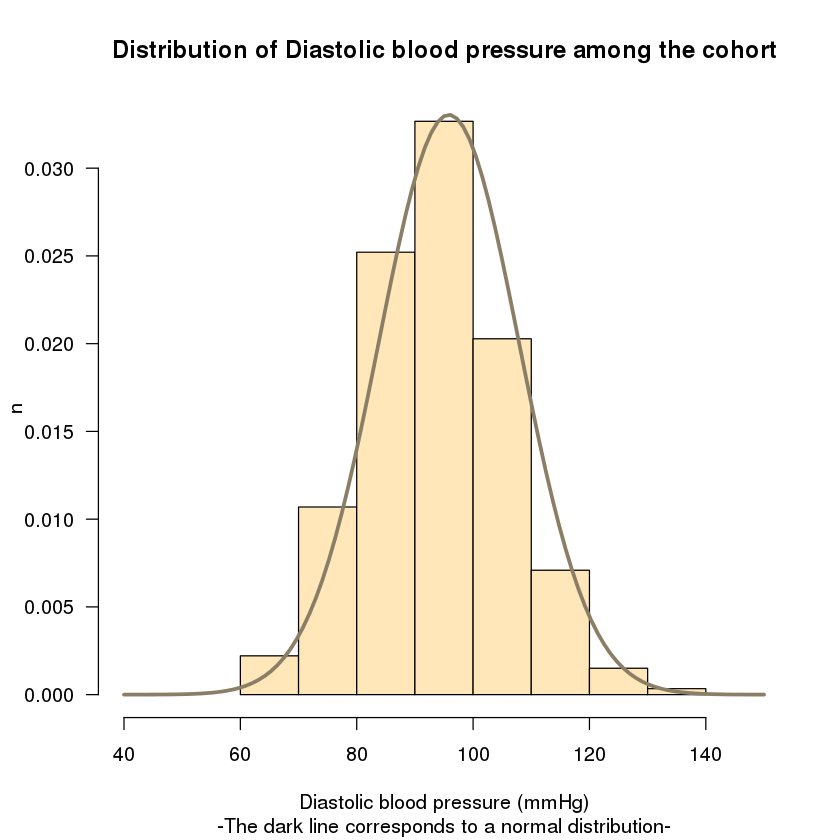

In [8]:
diastolic <- demo$Diastolic_BP
summary(diastolic)
hist(diastolic,
     main="Distribution of Diastolic blood pressure among the cohort",
     sub="-The dark line corresponds to a normal distribution-",
     xlab="Diastolic blood pressure (mmHg)", 
     ylab="n",
     border="black", 
     col="wheat1",
     xlim=c(40,150),
     breaks=10,
     las = 1,
     prob = TRUE
    )
m <- mean(diastolic, na.rm = TRUE)
std <- sqrt(var(diastolic, na.rm = TRUE))
x <- length(diastolic)
curve(dnorm(x, mean=m, sd=std), col="wheat4", lwd=3, add=TRUE, yaxt="n")

We can see that the distribution as a bell-shape curve slightly left skewed. However, our population contains enough patient so that we can apply the central limit theorem for our analysis.

Let's run a t-test in order to look for a significant difference of the diastolic BP between men and women.

In [9]:
t.test(diastolic~Gender)
boxplot(diastolic~Gender,data=demo, main="Diastolic blood pressure by Gender", xlab="Gender", ylab="Diastolic blood pressure (mmHg)",   las = 1)

ERROR: Error in eval(expr, envir, enclos): object 'Gender' not found


The p-value is lower than 0.05, therefore we can conclude that the dastolic blood pressure is statistically significantly lower among the female population of the Jackson cohort than among the male population. This is also visualy significant as looking at the box-plots.

### 2.c. Comparison of 2 categorical variables
Let's analyze the tobacco epidemic among the Jackson Heart Study cohort subjects.
#### Firstly, we want to know the proportion of smokers, broken down by gender

        Smokers
Gender     No  Yes
  Female 1630  580
  Male    734  586


	Pearson's Chi-squared test with Yates' continuity correction

data:  Gender and Smokers
X-squared = 122.24, df = 1, p-value < 2.2e-16


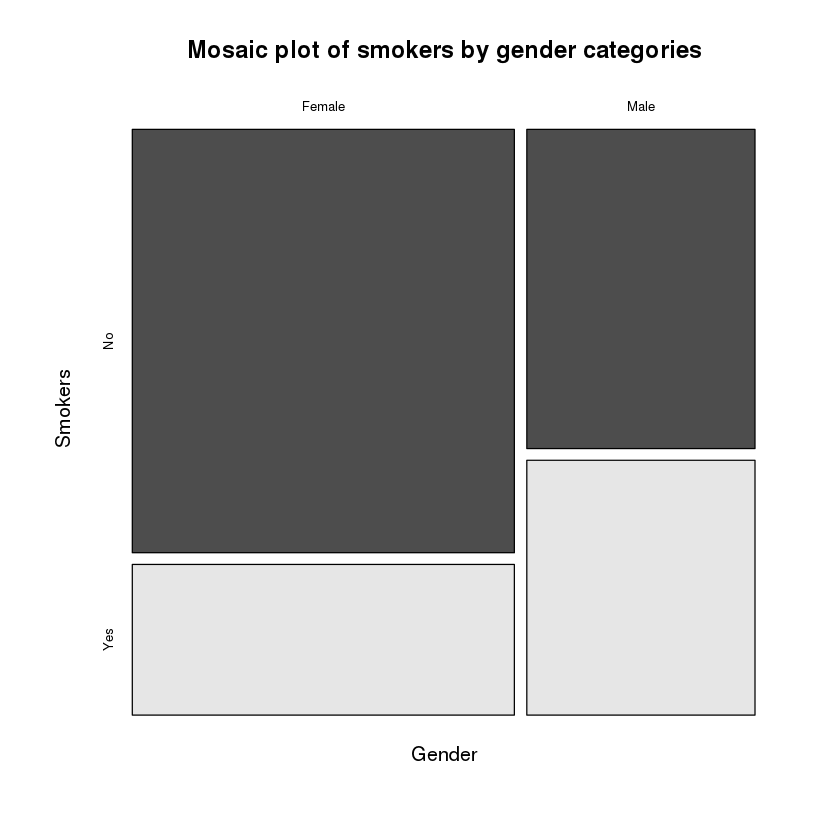

In [10]:
demo <- demo[((demo$Gender == "Male" | demo$Gender == "Female")
            & (demo$Smoking == "Yes" | demo$Smoking == "No")),]
demo <- droplevels(demo)

Smokers <- demo$Smoking
Gender <- demo$Gender

TwoByTwo <- table(Gender, Smokers)
TwoByTwo
chisq.test(Gender, Smokers)
mosaicplot(TwoByTwo, color = TRUE, main = "Mosaic plot of smokers by gender categories")

The previous Chi-Square test concluded that there was a statistically significant higher proportion of smokers among men than among women. That is also visually significant on the mosaic plot.

### 3. Focus on Myocardial hypertrophy
#### 3.1 Distribution
Histogram showing the distribution of the interventricular septum thickness measurement during the ventricular contraction.

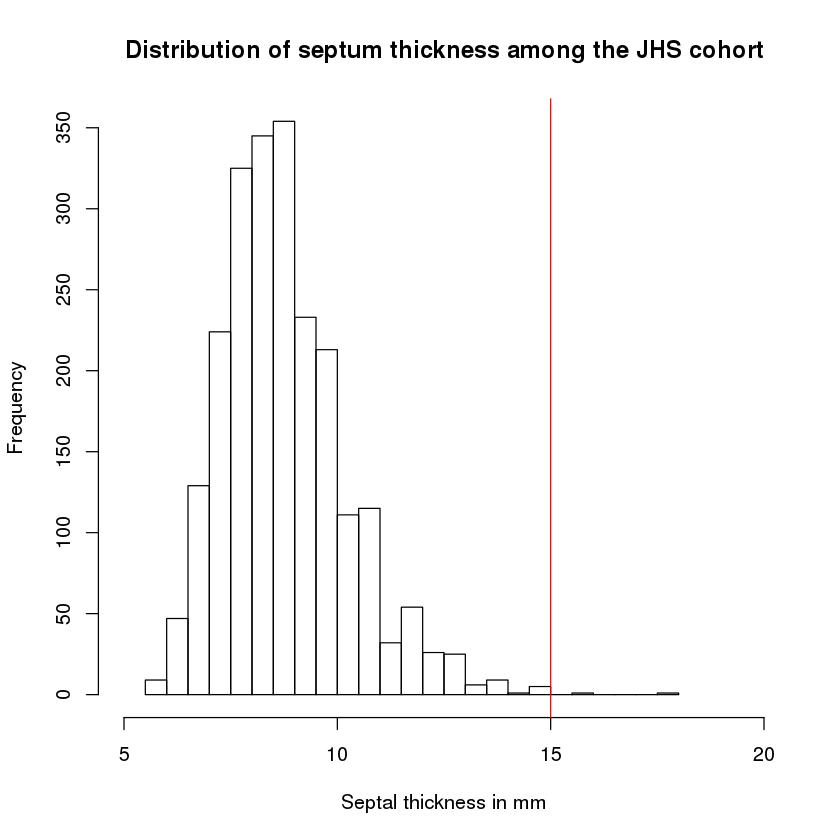

In [11]:
demo <- demo[!(is.na(demo$LV_thickness)),]
hist(demo$LV_thickness,
     xlab="Septal thickness in mm",
     main = "Distribution of septum thickness among the JHS cohort",
     xlim=c(5,20),
     breaks=19)
abline(v=15,col="red")

The distribution among our population doesn't seem to fit a bell-shaped curve. It's left-skewed, and with a right tail. The red line drawn at 15mm represent the threshold above which myocardial hypertrophy is defined.

#### 3.2 Comparison between male and female

We can now run a t-test in order to compare the wall thickness of the interventricular septum between females and males.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5.500   7.800   8.700   8.855   9.600  17.800 

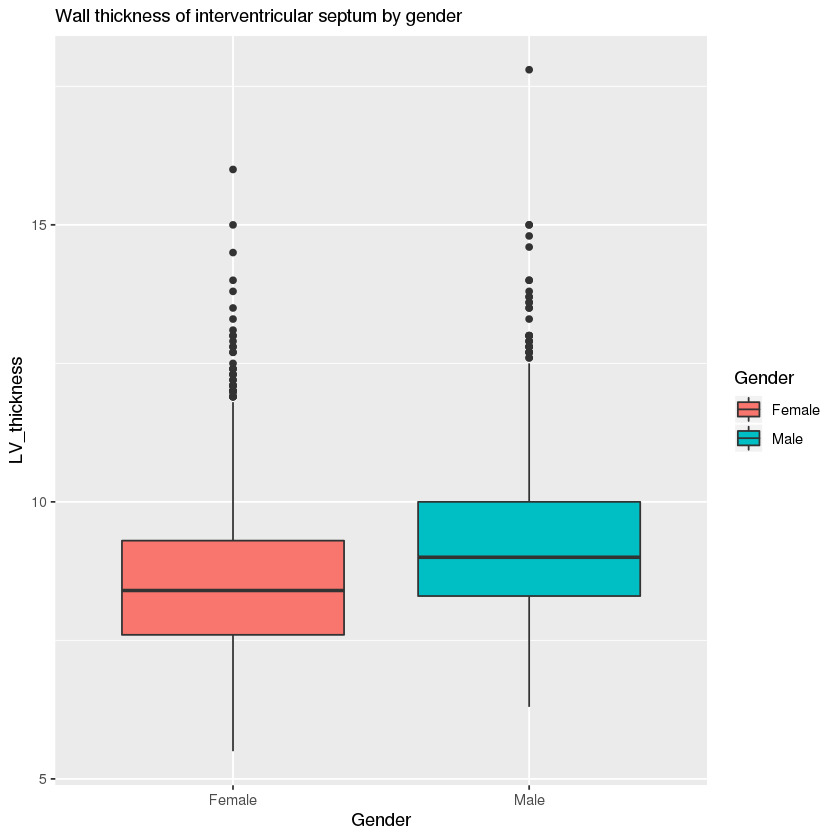

In [12]:
demo2 <- demo[(demo$Gender == "Female" | demo$Gender == "Male"),]

LV_thickness <- demo$LV_thickness
Gender <- demo2$Gender

summary(LV_thickness)

p <- ggplot(demo, aes(x=Gender, y=LV_thickness, fill=Gender)) + geom_boxplot()
p + labs(subtitle="Wall thickness of interventricular septum by gender")

In [13]:
t.test(LV_thickness~Gender)


	Welch Two Sample t-test

data:  LV_thickness by Gender
t = -10.324, df = 1668.8, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.7824201 -0.5325810
sample estimates:
mean in group Female   mean in group Male 
            8.607371             9.264871 


The p-value is lower than 0.05, therefore we can conclude that the interventricular septum thickness is significantly lower among the female population of the Jackson cohort than among the male population.

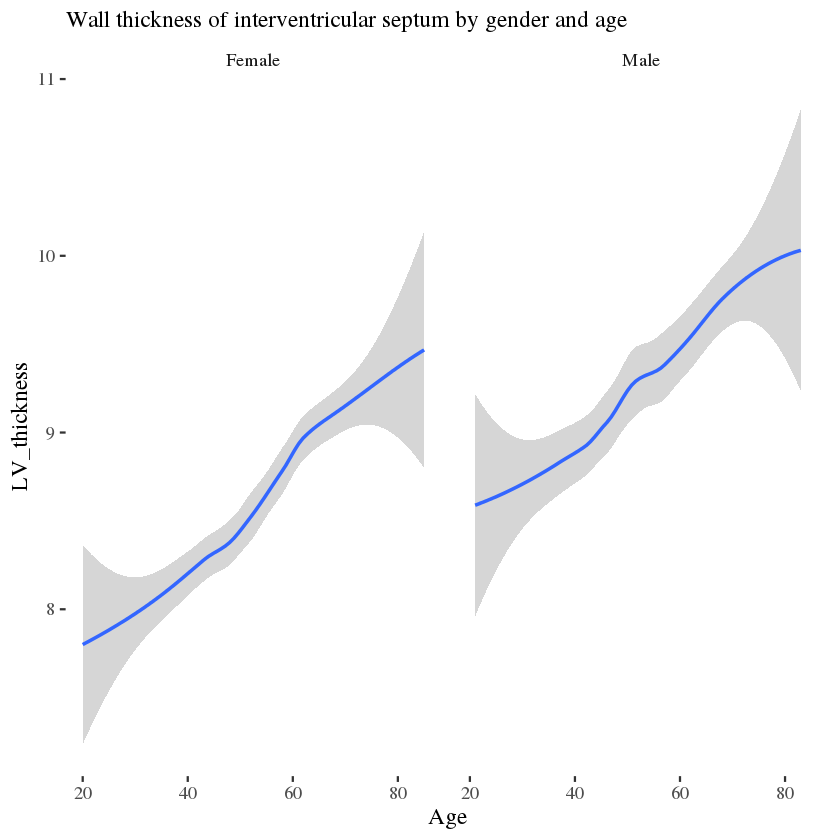

In [14]:
p <- ggplot(data=demo,aes(x=Age,y=LV_thickness))
p + theme_tufte(base_size=14) + stat_smooth(method='loess') + facet_grid(~Gender) + labs(subtitle="Wall thickness of interventricular septum by gender and age")